# IAR6 Exercise

$\textbf{Cruise}:$ The robot drives straight forward. 

$\textbf{Avoid}:$ If an obstacle is detected on the left side, the robot turns right until the obstacle is no longer detected. If an obstacle is detected on the right side, the robot turns left. 

$\textbf{Escape}:$ If a collision is detected, the robot backs up for $t_b = 2~\textrm{s}$. Afterwards, it spins for $t_s = 2~\textrm{s}$.  


In [1]:
import time
from loop_rate_limiters import RateLimiter
import random
import numpy as np
from multiprocessing import shared_memory
from random import seed as py_seed
import math
import copy
import matplotlib.pyplot as plt
# import thymiodirect package
from thymiodirect import Connection 
from thymiodirect import Thymio

NAME = "thymio_data"
N = 4
AXLE_LENGTH  = 0.094  
v = 0.15 

seed = 100 
np.random.seed(seed)
py_seed(seed)

In [2]:
def compute_wheel_speeds(theta0, theta_target, v, t, k_theta=1.0):
    # 1) Angle error (wrapped to [-pi, +pi])
    e_theta = theta_target - theta0
    e_theta = math.atan2(math.sin(e_theta), math.cos(e_theta))

    if (t%50 == 0):
        print(t, e_theta, "extra")

    # 2) Desired angular velocity
    omega = k_theta * e_theta

    # 3) Convert robot (v, omega) → wheel linear speeds
    v_R = v + (omega * AXLE_LENGTH / 2)
    v_L = v - (omega * AXLE_LENGTH / 2)

    # 4) scaling to target speed
    s_R = v_R * 1000
    s_L = v_L * 1000

    return s_L, s_R

In [3]:
def compute_h_ext(ring, theta_diff):
    difference_target = (ring.thetas - theta_diff + np.pi) % (2 * np.pi) - np.pi
    ring.h_ext = (ring.h_0 / np.sqrt(2 * np.pi * (ring.sigma_ang**2))) * np.exp(- (difference_target ** 2) / (2 * (ring.sigma_ang**2) ) )

def compute_J(ring,i):
    kernel = None
    alpha_i = copy.deepcopy(ring.thetas[i])
    angle_diffs = np.abs((copy.deepcopy(ring.thetas) - alpha_i + np.pi) % (2 * np.pi) - np.pi)
    kernel = np.cos(np.pi * ((angle_diffs / np.pi) ** ring.v))
    return kernel

def compute_delta_H(ring, i):
    H = np.zeros(2)
    j_curr = compute_J(ring,i)
    j_curr[i] = 0 

    interaction_sum = np.dot(j_curr, ring.spins)
   
    spin_flip = np.array([ring.spins[i], 1-ring.spins[i]])

    interaction_energy = (interaction_sum * spin_flip) / (ring.Ns - 1)

    if ring.h_ext is None:
        input_energy = 0
    else:
        input_energy = ring.h_ext[i] * spin_flip

    leak_energy = ring.h_b * spin_flip
    H = -1 * (interaction_energy + input_energy - leak_energy)
    return (H[1] - H[0])

def plot_summary_no_target(ring,pos_alloc,pos_ego,spins_history,bump_angles,L):
    fig, axes = plt.subplots(1, 3, figsize=(15, 9))

    # network activity as a function of time
    ax_raster = axes[0] 
    im = ax_raster.imshow(spins_history.T, aspect='auto', origin='lower',
                        cmap='gray', interpolation='nearest', extent=[0, L, -180, 180])
    ax_raster.set_title(f" beta={ring.beta:.2f}  — network spins over time")
    ax_raster.set_ylabel("unit index")
    ax_raster.set_xlabel("time step")
    time_axis = np.arange(L) 
    ax_raster.plot(time_axis, bump_angles, color='red', linewidth=2, label='bump angle')

    # Add legend (colorbar)
    cbar = plt.colorbar(im, ax=ax_raster, ticks=[0, 1])
    cbar.ax.set_yticklabels(['0 (black)', '1 (white)'])
    cbar.set_label("Spin value")

    # egocentric trajectory
    ax_ego = axes[1] 
    pos = pos_ego
    ax_ego.plot(pos[:, 0], pos[:, 1], linewidth=1)
    ax_ego.scatter(pos[0, 0], pos[0, 1], color='green', s=20, label='start')
    ax_ego.scatter(pos[-1, 0], pos[-1, 1], color='red', s=20, label='end')
    ax_ego.set_title(f" Egocentric (beta={ring.beta:.2f})")
    ax_ego.set_aspect('equal')
    ax_ego.set_xlabel("x")
    ax_ego.set_ylabel("y")
    ax_ego.legend()

    # allocentric trajectory
    ax_alloc = axes[2] 
    pos = pos_alloc
    ax_alloc.plot(pos[:, 0], pos[:, 1], linewidth=1)
    ax_alloc.scatter(pos[0, 0], pos[0, 1], color='green', s=20, label='start')
    ax_alloc.scatter(pos[-1, 0], pos[-1, 1], color='red', s=20, label='end')
    ax_alloc.set_title(f" Allocentric (beta={ring.beta:.2f})")
    ax_alloc.set_aspect('equal')
    ax_alloc.set_xlabel("x")
    ax_alloc.set_ylabel("y")
    ax_alloc.legend()

    plt.tight_layout()
    plt.show()

def plot_summary_with_target(ring,pos,spins_history,bump_angles,target_pos,L,end_needed=True):
    fig, axes = plt.subplots(1, 2, figsize=(15, 9))

    # network activity as a function of time
    ax_raster = axes[0] 
    im = ax_raster.imshow(spins_history.T, aspect='auto', origin='lower',
                        cmap='gray', interpolation='nearest', extent=[0, L, -180, 180])
    ax_raster.set_title(f" beta={ring.beta:.2f}  — network spins over time")
    ax_raster.set_ylabel("unit index")
    ax_raster.set_xlabel("time step")
    time_axis = np.arange(L) 
    ax_raster.plot(time_axis, bump_angles[0:L], color='red', linewidth=2, label='bump angle')

    # Add legend (colorbar)
    cbar = plt.colorbar(im, ax=ax_raster, ticks=[0, 1])
    cbar.ax.set_yticklabels(['0 (black)', '1 (white)'])
    cbar.set_label("Spin value")

    #  trajectory
    ax_alloc = axes[1] 
    ax_alloc.plot(pos[:L, 0], pos[:L, 1], linewidth=1)
    ax_alloc.scatter(pos[0, 0], pos[0, 1], color='green', s=20, label='start')
    if end_needed:
        ax_alloc.scatter(pos[-1, 0], pos[-1, 1], color='red', s=20, label='end')
    ax_alloc.scatter(*target_pos, color='black', marker='x', s=40, label='target')
    ax_alloc.set_title(f" Allocentric (beta={ring.beta:.2f})")
    ax_alloc.set_aspect('equal')
    ax_alloc.set_xlabel("x")
    ax_alloc.set_ylabel("y")

    plt.tight_layout()
    plt.show()

def plot_any_line(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.show()

def plot_only_bump(ring,spins_history,bump_angles,L):
    fig, axes = plt.subplots(1, 2, figsize=(15, 9))

    # network activity as a function of time
    ax_raster = axes[0] 
    im = ax_raster.imshow(spins_history.T, aspect='auto', origin='lower',
                        cmap='gray', interpolation='nearest', extent=[0, L, -180, 180])
    ax_raster.set_title(f" beta={ring.beta:.2f}  — network spins over time")
    ax_raster.set_ylabel("unit index")
    ax_raster.set_xlabel("time step")
    time_axis = np.arange(L) 
    ax_raster.plot(time_axis, bump_angles[0:L], color='red', linewidth=2, label='bump angle')

    # Add legend (colorbar)
    cbar = plt.colorbar(im, ax=ax_raster, ticks=[0, 1])
    cbar.ax.set_yticklabels(['0 (black)', '1 (white)'])
    cbar.set_label("Spin value")

    plt.tight_layout()
    plt.show()

In [4]:
class RA():
    def __init__(self):
        self.Ns = 100
        self.v = 0.5
        self.h_0 = 0
        self.h_b = 0
        self.v_0 = 1
        self.h_ext = None
        self.beta = 4000.0
        self.sigma_ang = 2*np.pi/self.Ns
        self.thetas = np.linspace(-np.pi, np.pi, self.Ns, endpoint=False)
        self.spins = np.random.choice([1,0], size=self.Ns)
        self.pos = np.zeros(2)
        self.heading = 0
        self.updates_per_step = int(round(self.Ns * 10))

ring = RA()
L = 1000

bump_angles = np.zeros(L)
spins_history = np.zeros((L, ring.Ns), dtype=int)

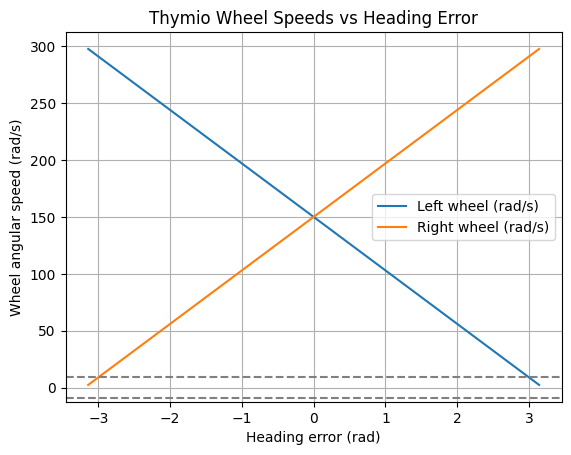

In [5]:
N = 100
theta0 = 0          # initial heading

theta_values = np.linspace(-math.pi, math.pi, N)
left_values  = []
right_values = []

for theta_target in theta_values:
    wL, wR = compute_wheel_speeds(theta0, theta_target, v, 1)
    left_values.append(wL)
    right_values.append(wR)

import matplotlib.pyplot as plt

plt.plot(theta_values, left_values, label="Left wheel (rad/s)")
plt.plot(theta_values, right_values, label="Right wheel (rad/s)")
plt.axhline( 9.53, color='gray', linestyle='--')
plt.axhline(-9.53, color='gray', linestyle='--')
plt.xlabel("Heading error (rad)")
plt.ylabel("Wheel angular speed (rad/s)")
plt.title("Thymio Wheel Speeds vs Heading Error")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Set to True to use the Thymio simulator
use_simulator = True

# Sets the rate limiter to control the loop frequency in Hz
rate = RateLimiter(frequency=10.0) 

if use_simulator:
    port = 2001
    th = Thymio(use_tcp=True, host='localhost', tcp_port=port, on_connect=lambda node_id: print(f' Thymio {node_id} is connected'))
else:
    port = Connection.serial_default_port()
    th = Thymio(serial_port=port, on_connect=lambda node_id: print(f' Thymio {node_id} is connected'))

# Connect to Robot
th.connect()
robot = th[th.first_node()]

# Delay to allow robot initialization of all variables
time.sleep(1)


 Thymio 1 is connected


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-114' coro=<Connection.handle_message.<locals>.do_refresh() done, defined at /Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/thymiodirect/connection.py:451> exception=KeyError(1)>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/thymiodirect/connection.py", line 458, in do_refresh
    self.get_variables(source_node)
    ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/thymiodirect/connection.py", line 571, in get_variables
    chunk_length = (self.get_target_node_var_total_size(target_node_id)
                    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/thymiodirect/connection.py", line 536, in get_target_node_var_total_size
    retur

In [7]:
# don't delete the try-finally block, add your code inside the try block
shm = shared_memory.SharedMemory(name=NAME, create=False)
arr = np.ndarray((N,), dtype=np.float64, buffer=shm.buf)

print("Attached to shared memory. Reading latest values...")  

try:
    # Main loop
    for t in range (L):
        for _ in range (ring.updates_per_step):
            i = np.random.randint(0,ring.Ns)
            delta_H = compute_delta_H(ring,i)

            if delta_H < 0:
                # Energy difference negative — always accept
                ring.spins[i] = 1 - ring.spins[i]
            else:
                # Energy difference positive — accept with probability exp(-beta * delta_H)
                p = np.exp(-ring.beta * delta_H)
                if np.random.rand() < p:
                    ring.spins[i] = 1 - ring.spins[i]
                    
        active_indices = np.where(ring.spins == 1)[0]
        n_active = len(active_indices)
        if n_active > 0:
            phi = np.angle(np.sum(np.exp(1j * ring.thetas[ring.spins == 1])))
        else:
            phi = 0.0
        if (t%50 == 0):
            print(t, phi)
        local_copy = arr.copy()
        bump_angles[t] = math.degrees(phi)
        spins_history[t] = copy.deepcopy(ring.spins)
        # sL, sR = compute_wheel_speeds(local_copy[3], phi, v, t) # for allocentric
        sL, sR = compute_wheel_speeds(local_copy[3], (local_copy[3] + phi), v, t) # egocentric
        # print('thymio position : [ %f %f %f ] \n' %(local_copy[0], local_copy[1], local_copy[2]))
        robot['motor.left.target'] = int(sL)
        robot['motor.right.target'] = int(sR)
        
        rate.sleep()
finally:
    robot['motor.left.target'] = 0
    robot['motor.right.target'] = 0
    shm.close()
    print("Interrupted")

Attached to shared memory. Reading latest values...
0 -2.261946710584651
0 -2.261946710584651 extra
50 -2.261946710584651
50 -2.261946710584651 extra
100 -2.261946710584651
100 -2.261946710584651 extra
150 -2.261946710584651
150 -2.261946710584651 extra
200 -2.261946710584651
200 -2.261946710584651 extra
250 -2.261946710584651
250 -2.261946710584651 extra
300 -2.3247785636564466
300 -2.324778563656447 extra
350 -2.3247785636564466
350 -2.3247785636564466 extra
400 -2.3247785636564466
400 -2.3247785636564466 extra
450 -2.3247785636564466
450 -2.3247785636564466 extra
500 -2.3247785636564466
500 -2.3247785636564466 extra
550 -2.3247785636564466
550 -2.3247785636564466 extra
600 -2.3247785636564466
600 -2.324778563656447 extra
650 -2.3247785636564466
650 -2.3247785636564466 extra
700 -2.3247785636564466
700 -2.3247785636564466 extra
750 -2.3247785636564466
750 -2.3247785636564466 extra
800 -2.3247785636564466
800 -2.3247785636564466 extra


850 -2.3247785636564466
850 -2.3247785636564466 extra
900 -2.3247785636564466
900 -2.3247785636564466 extra
950 -2.3247785636564466
950 -2.3247785636564466 extra
Interrupted


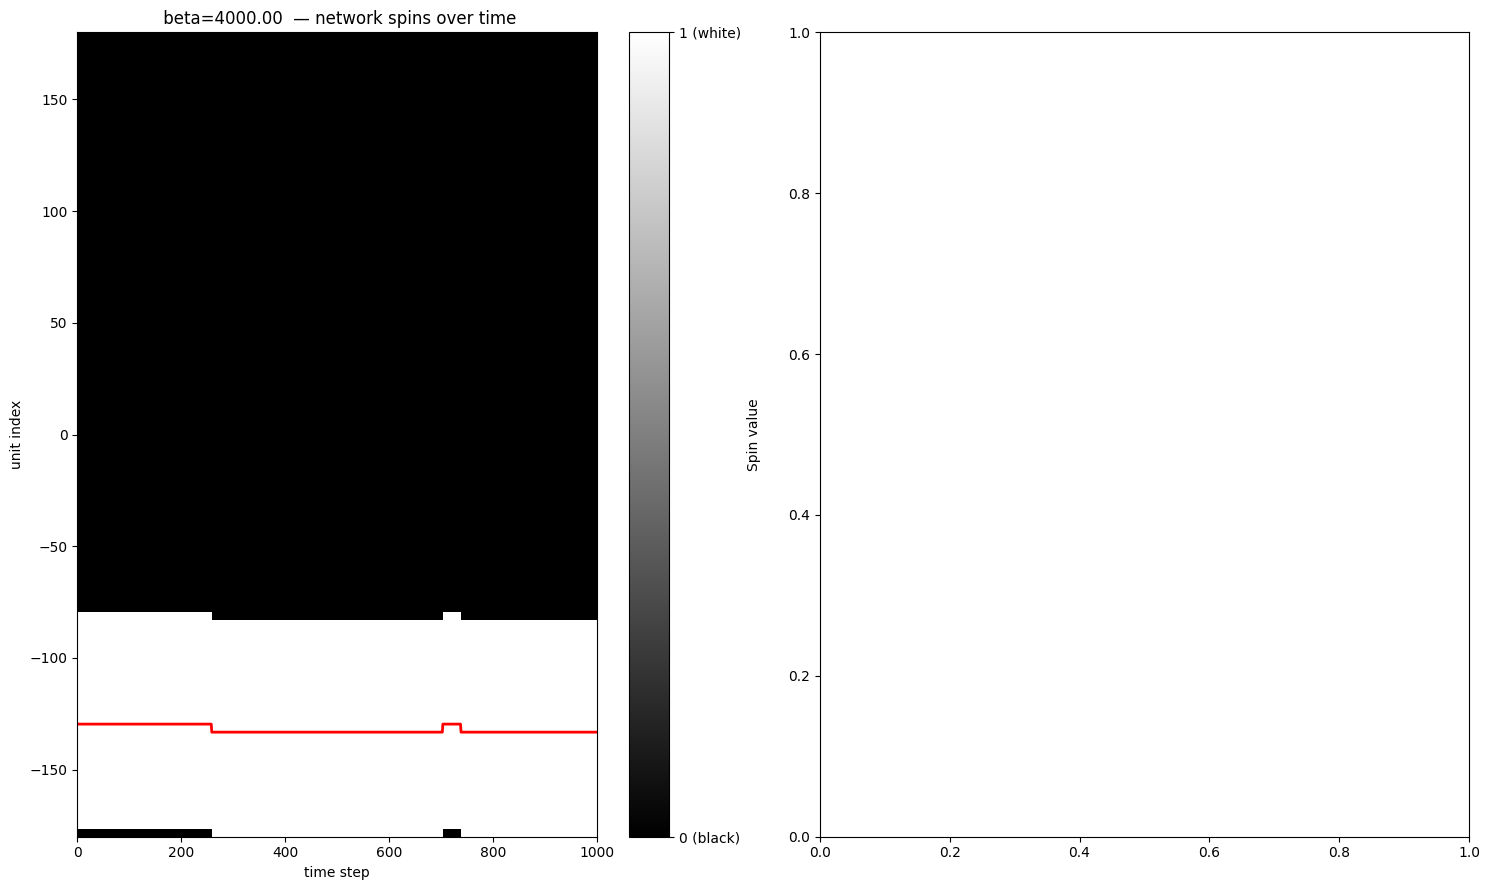

In [8]:
plot_only_bump(ring,spins_history,bump_angles,L)